### Imports

In [120]:
import nltk
from nltk.corpus import brown
from nltk.corpus import stopwords
import string
# nltk.download('punkt') # Download the 'punkt' tokenizer
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
import numpy as np
import gensim
import re
import pandas as pd
import os
from tabulate import tabulate
from gensim.models.phrases import Phrases, Phraser
nltk.download('stopwords')
import pickle
import itertools  #used for flattening lists of lists
import math
import csv
from help_functions import test_dictionary
from help_functions import get_next_qtr



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ImportError: cannot import name 'get_next_qtr' from 'help_functions' (c:\Users\Steve\Documents\Grad School\Capstone\msds_capstone\help_functions.py)

## Stop Words, CSV Files, and Year List, SNL_Map

In [117]:
nltk_stop_words = set(stopwords.words('english'))
words_to_remove = ['below', 'haven']   #reasonable words to be meaningful
stop_words = list(filter(lambda word: word not in words_to_remove, nltk_stop_words))
print(stop_words)

### create list of csv files and years
csv_files = [os.path.join('data', file) for file in os.listdir('data')]
years_list = list(range(2009, 2025))
print('')
print(csv_files)

### create a look up file to get ciq id and map to related snl id
snl_ciq_map = {}
with open('snldata/SNl_CIQ_MAP.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        snl_ciq_map[row[1][2:]] = row[0]

### import csv as dataframes for transcript/company ids and loan data/snl ids
snl_df = pd.read_csv('snldata/snldata_output.csv', encoding='utf-8')
transcript_id_df = pd.read_csv('snldata/transcriptid_company_id_date.csv', encoding='utf-8')

### Create blank dataframe to hold loan movement data
columns = ['transcript_id', 'ciq_id', 'snl_id', 'quarter', 'year','uncertainty_score','total_asset_before','total_asset_after',
           'loan_before','loan_after','l2a_delta']
delta_df = pd.DataFrame(columns=columns)
print(f'mapping files have been loaded in')

["that'll", 'each', 'off', 'once', 'about', "hadn't", "should've", 'we', 'yourselves', 'have', 'herself', 'too', 'down', 'up', 'then', 'll', 'because', 'during', 'further', 'most', 'shouldn', 'with', 'through', 'he', 'the', 'which', 'it', 'in', 'your', 'yourself', 'while', "didn't", 'doing', 'don', 'won', 'aren', 'for', 'ourselves', "wasn't", 'doesn', 'same', 'been', 'or', 'hadn', 'm', 'from', "haven't", 'again', 'here', 'what', 'this', 'her', 'should', 'having', 's', "you'll", "wouldn't", 'hasn', 'mustn', 'such', "mightn't", 'theirs', 'had', 'is', 'wouldn', 'few', 'when', "weren't", "mustn't", 'against', 'shan', 'can', 'and', 'so', 'they', "she's", 'be', "doesn't", 'has', 'to', 'a', 'no', 'some', 'being', 'not', 'i', 'those', 'if', 'before', 'between', 't', 'under', 'any', 'isn', 'did', 'ain', 'their', 'an', 'now', 'how', 'there', 'd', 'themselves', 'yours', 'ma', 'on', 'until', 'at', 'after', 'am', 'o', 'wasn', 'other', 'were', "won't", 'nor', 'all', 'into', 'him', "you're", 'will', 

In [49]:
print(get_next_qtr('Q4 2023'))

Q1 2024


In [63]:
print(uncertainty_score_dict['209654'])

KeyError: '209654'

In [104]:
transcript_id = 1898433
row = transcript_id_df[transcript_id_df['TRANSCRIPTID'] == transcript_id]
print(f'row: {row}')
ciq_id = str(row['COMPANYID'].values[0])
snl_id = int(snl_ciq_map[ciq_id])
print(type(snl_id))
uncertainty_score = uncertainty_score_dict[transcript_id]
quarter = row['QUARTER'].values[0]
next_quarter = get_next_qtr(quarter)
print(f'CIQ ID: {ciq_id}, SNL ID: {snl_id} uncertainty score: {uncertainty_score}, quarter: {quarter}, nxt_qtr: {next_quarter}')
total_asset_before = snl_df[(snl_df['QUARTER'] == quarter) & (snl_df['INSTITUTIONID'] == snl_id) & (snl_df['DATAITEMID'] == 206118)]['DATAITEMVALUE'].values[0]

print(type(total_asset_before))

row:     COMPANYID  COMPANYNAME   KEYDEVID  QUARTER DATE(E.MOSTIMPORTANTDATEUTC)  \
27   47416993  Altabancorp  650110156  Q4 2019                   2020-01-29   

    TRANSCRIPTID  
27       1898433  
<class 'int'>
CIQ ID: 47416993, SNL ID: 4048950 uncertainty score: 0.0017376194613379669, quarter: Q4 2019, nxt_qtr: Q1 2020


IndexError: index 0 is out of bounds for axis 0 with size 0

In [105]:
for index, row in transcript_id_df.iterrows():
    transcript_id = int(row['TRANSCRIPTID'])
    # print(transcript_id)
    ciq_id = str(row['COMPANYID'])
    date = row['DATE(E.MOSTIMPORTANTDATEUTC)']
    # print(ciq_id)

    try:
        snl_id = int(snl_ciq_map[ciq_id])
        uncertainty_score = uncertainty_score_dict[transcript_id]
    except KeyError:
        print(f'snl id or uncertainty score error with transcript id {transcript_id}, date: {date}')
        continue

    quarter = row['QUARTER']
    year = row['QUARTER'][-4:]

    try:
        next_quarter = get_next_qtr(quarter)
    except Exception as e:
        # print(f'{e} was the error, the cause was: {quarter} with {transcript_id}, date: {date}')
        continue


    try:
        total_asset_before = snl_df[(snl_df['QUARTER'] == quarter) & (snl_df['INSTITUTIONID'] == snl_id)
                                    & (snl_df['DATAITEMID'] == 206118)]['DATAITEMVALUE'].values[0]
        total_asset_after = snl_df[(snl_df['QUARTER'] == next_quarter) & (snl_df['INSTITUTIONID'] == snl_id)
                                    & (snl_df['DATAITEMID'] == 206118)]['DATAITEMVALUE'].values[0]

        loan_before = snl_df[(snl_df['QUARTER'] == quarter) & (snl_df['INSTITUTIONID'] == snl_id)
                                    & (snl_df['DATAITEMID'] == 215825)]['DATAITEMVALUE'].values[0]
        loan_after = snl_df[(snl_df['QUARTER'] == next_quarter) & (snl_df['INSTITUTIONID'] == snl_id)
                                    & (snl_df['DATAITEMID'] == 215825)]['DATAITEMVALUE'].values[0]

        l2a_delta = loan_after/total_asset_after - loan_before/total_asset_before
    except Exception as e:

        # print(f'loan calc error with {transcript_id}, date: {date}')
        continue

    new_row = {'transcript_id':transcript_id, 'ciq_id':ciq_id, 'snl_id':snl_id, 'quarter':quarter, 'year':year,'uncertainty_score':uncertainty_score,
               'total_asset_before':total_asset_before,'total_asset_after':total_asset_after,'loan_before':loan_before,'loan_after':loan_after,
               'l2a_delta':l2a_delta}

    delta_df.loc[len(delta_df)] = new_row  # Adding at the next available index

    # print(f'SUCCESSFULLY ADDED ROW with {transcript_id}, date: {date}')







snl id or uncertainty score error with transcript id 610, date: 2008-04-17
snl id or uncertainty score error with transcript id 10084, date: 2008-07-17
snl id or uncertainty score error with transcript id 12721, date: 2008-10-16
snl id or uncertainty score error with transcript id 608, date: 2007-10-18
snl id or uncertainty score error with transcript id 609, date: 2008-01-22
snl id or uncertainty score error with transcript id 12752, date: 2008-10-16
snl id or uncertainty score error with transcript id 1041, date: 2008-04-24
snl id or uncertainty score error with transcript id 1040, date: 2008-01-31
snl id or uncertainty score error with transcript id 10100, date: 2008-07-14
snl id or uncertainty score error with transcript id 844, date: 2008-04-17
snl id or uncertainty score error with transcript id 843, date: 2007-10-18
snl id or uncertainty score error with transcript id 18008, date: 2008-07-17
snl id or uncertainty score error with transcript id 12719, date: 2008-10-16
snl id or u

In [109]:
print(delta_df.head())
print(len(delta_df))
print(delta_df['ciq_id'].nunique())

   transcript_id  ciq_id  snl_id  quarter  year  uncertainty_score  \
0          20338  247106  100130  Q1 2009  2009           0.004926   
1          51454  247106  100130  Q3 2009  2009           0.007508   
2        2476476  247106  100130  Q4 2008  2008           0.008444   
3          49999  247106  100130  Q4 2009  2009           0.006639   
4          33217  247106  100130  Q2 2009  2009           0.002392   

   total_asset_before  total_asset_after  loan_before  loan_after  l2a_delta  
0           5298989.0          4886120.0    3600357.0   3372129.0   0.010702  
1           4365383.0          3777368.0    3134440.0   2647755.0  -0.017069  
2           5060123.0          5298989.0    3792778.0   3600357.0  -0.070100  
3           3777368.0          3075744.0    2647755.0   2014656.0  -0.045938  
4           4886120.0          4365383.0    3372129.0   3134440.0   0.027877  
8104
262


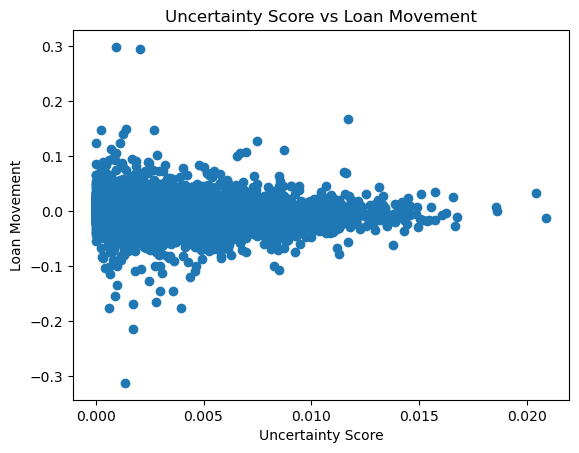

Correlation between Uncertainty Score and Loan Movement: -0.07234564566118847


In [112]:
import matplotlib.pyplot as plt

# Scatter plot of uncertainty score vs loan movement
plt.scatter(delta_df['uncertainty_score'], delta_df['l2a_delta'])
plt.xlabel('Uncertainty Score')
plt.ylabel('Loan Movement')
plt.title('Uncertainty Score vs Loan Movement')
plt.show()

correlation = delta_df['uncertainty_score'].corr(delta_df['l2a_delta'])
print(f"Correlation between Uncertainty Score and Loan Movement: {correlation}")

## Class Definition for Object Storage

In [3]:
class model_year:
  years = {}

  def __init__(self, year, model, uncertainty_wordlist, corpus_bigrams, bigram_dict, flat_corpus_bigrams):

    self.year = year
    self.model = model
    self.uncertainty_wordlist = uncertainty_wordlist
    self.corpus_bigrams = corpus_bigrams
    self.bigram_dict = bigram_dict
    self.flat_corpus_bigrams = flat_corpus_bigrams

    model_year.years[year] = self



## Functions

### Split Text Function

In [4]:
def split_text_to_sentences_words(text):
    # Split into sentences
    sentences = nltk.sent_tokenize(text)

    # Split each sentence into a list of words
    sentences_words = [nltk.word_tokenize(sentence) for sentence in sentences]

    return sentences_words

### Get Corpus, Process Data, and Create Bigrams

In [5]:


def get_corpus(csv_file):

   df = pd.read_csv(csv_file, encoding='utf-8')

   df['COMPONENTTEXT_SPLIT'] = df['COMPONENTTEXT'].apply(split_text_to_sentences_words)
   # print(f'split text has been applied:')
   # print(tabulate(df.head(2), headers='keys', tablefmt='pretty'))

   unprocessed_dict = {}
   for row in df.itertuples():
      if row.TRANSCRIPTID not in unprocessed_dict:
         unprocessed_dict[row.TRANSCRIPTID] = row.COMPONENTTEXT_SPLIT
      else:
         unprocessed_dict[row.TRANSCRIPTID].extend(row.COMPONENTTEXT_SPLIT)
   return(unprocessed_dict)

def process_the_data(unprocessed_dict, stop_words):
   num_tokens_before = 0
   num_tokens_after = 0
   processed_dict = {}

   for transcriptid, text in unprocessed_dict.items():
      p_text = []
      for sentence in text:
         p_sentence = []
         for word in sentence:
            num_tokens_before += 1
            p_word = word.lower()                                  #lowercase the text
            p_word = re.sub(r'(?<!\w)-(?!\w)|[^\w\s-]', '', p_word)  #remove punctuation but keep hyphens
            if p_word in stop_words or len(p_word) == 0:             #ignore if word has no length (ie was punctuation only) or in stop words
               continue
            p_sentence.append(p_word)
         p_text.append(p_sentence)
         num_tokens_after += len(p_sentence)
      processed_dict[transcriptid] = p_text

   # print(f'Number of Tokens before processing: {num_tokens_before:,}')
   # print(f'Number of Tokens after processing: {num_tokens_after:,}')
   # print(f'Process Sentence Examples:')

   # for index, (key, value) in enumerate(processed_dict.items()):
   #    print(f'{key}: {value}')
   #    if index == 2:
   #       break

   return processed_dict

def create_bigrams(processed_dict, min_count=10, threshold = 100):

   processed_corpus = [['']]
   for value in processed_dict.values():
      processed_corpus.extend(value)

   phrases = Phrases(processed_corpus, min_count, threshold, scoring='default')
   bigram_phraser = Phraser(phrases)

   corpus_bigrams = [['']]

   dict_bigrams = {}
   for transcript_id, text in processed_dict.items():
      bigram_text = [bigram_phraser[sentence] for sentence in text]
      dict_bigrams[transcript_id] = bigram_text
      corpus_bigrams.extend(bigram_text)


   flat_corpus_bigrams = [item for sublist in corpus_bigrams for item in sublist]

   # print('bigrams created')
   return phrases, bigram_phraser, corpus_bigrams, dict_bigrams, flat_corpus_bigrams



### Word2Vec Model

In [6]:

def apply_word2vec(corpus_bigrams):
   model = gensim.models.Word2Vec (
    vector_size=150,    # Number of features in word vector

    window=10,   # Context window size (in each direction). Default is 5


    min_count=5, # Words must appear this many times to be in vocab.
                 #   Default is 5

    workers=10,  # Training thread count

    sg=1,        # 0: CBOW, 1: Skip-gram.

    hs=0,        # 0: Negative Sampling, 1: Hierarchical Softmax
                 #   Default is 0, NS

    negative=5   # Nmber of negative samples
                 #   Default is 5
   )

   model.build_vocab(
    corpus_bigrams,
    progress_per=20000  # Tweaks how often progress is reported
   )

   print('Training the model...')

   model.train(
    corpus_bigrams,
    total_examples=len(corpus_bigrams),
    epochs=10,        # How many training passes to take.
    report_delay=10.0 # Report progress every 10 seconds.
   )

   print(' Modeling Training Done.')
   print('')

   return(model)

## Run Models

In [7]:
for index, file in enumerate(csv_files):
    corpus_dict = get_corpus(file)
    processed_corpus_dict = process_the_data(corpus_dict, stop_words)
    phrases, bigram_phraser, corpus_bigrams, dict_bigrams, flat_corpus_bigrams = create_bigrams(processed_corpus_dict)
    trained_model = apply_word2vec(corpus_bigrams)

    similar_words = trained_model.wv.most_similar('uncertainty', topn=100)
    word_list = [word for word, number in similar_words]


    model_year(year=years_list[index], model=trained_model, uncertainty_wordlist=word_list,
               corpus_bigrams=corpus_bigrams, bigram_dict = dict_bigrams, flat_corpus_bigrams = flat_corpus_bigrams)


print('done!!')

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

Training the model...
 Modeling Training Done.

done!!


In [21]:
for i, (key, value) in enumerate(corpus_dict.items()):
    if i >= 5:  # Stop after the first 5 items
        break
    print(f"{key}: {value}")

3006899: [['Good', 'morning', ',', 'ladies', 'and', 'gentlemen', ',', 'and', 'welcome', 'to', 'the', 'Amalgamated', 'Financial', 'Corporation', 'Fourth', 'Quarter', 'and', 'Full', 'Year', '2023', 'Earnings', 'Conference', 'Call', '.'], ['As', 'a', 'reminder', ',', 'this', 'conference', 'call', 'is', 'being', 'recorded', '.'], ['I', 'would', 'now', 'like', 'to', 'turn', 'the', 'call', 'over', 'to', 'Mr.', 'Jason', 'Darby', ',', 'Chief', 'Financial', 'Officer', '.'], ['Please', 'go', 'ahead', ',', 'sir', '.'], ['Thank', 'you', ',', 'operator', ',', 'and', 'good', 'morning', ',', 'everyone', '.'], ['We', 'appreciate', 'your', 'participation', 'in', 'our', 'fourth', 'quarter', '2023', 'earnings', 'call', '.'], ['With', 'me', 'today', 'is', 'Priscilla', 'Brown', ',', 'our', 'President', 'and', 'Chief', 'Executive', 'Officer', '.'], ['As', 'a', 'reminder', ',', 'a', 'telephonic', 'replay', 'of', 'this', 'call', 'will', 'be', 'available', 'on', 'our', 'Investors', 'section', 'of', 'our', 'web

## Get Word Lists

In [9]:
for key, value in model_year.years.items():

    print(f'{key}: {value.uncertainty_wordlist}')

2009: ['turbulence', 'looming', 'obstacles', 'removes', 'crystal_ball', 'harsh', 'disruptions', 'unsettled', 'monetary', 'keenly', 'unknowns', 'amidst', 'turndown', 'instability', 'overriding', 'rebounds', 'evolution', 'unprecedented', 'unpredictable', 'undue', 'dissatisfied', 'certainty', 'guarded', 'exists', 'fear', 'onerous', 'economic', 'mid-west', 'predictions', 'political', 'faces', 'enormous', 'safety', 'dire', 'escalating', 'abundance', 'monetary_fiscal', 'uncertain', 'macroeconomic', 'accurately', 'fragile', 'uncertainties', 'precision', 'waters', 'forthcoming', 'questioning', 'predictability', 'enthusiasm', 'stressful', 'prudence', 'toll', 'healthier', 'relevance', 'plaguing', 'stimulus', 'prevailing', 'increasingly', 'recognizes', 'unforeseen', 'lingering', 'impossible', 'wrestling', 'latitude', 'legislative_regulatory', 'overshadowed', 'overcome', 'prospectively', 'navigating', 'gratifying', 'assurance', 'poised', 'caution', 'confront', 'stimulate', 'prospect', 'unfold', 's

In [10]:
# idf_scores = {}
# n = len(years_list)

# for object in model_year.years.values():
#     for word in object.uncertainty_wordlist:
#         if word not in idf_scores.keys():
#             count = 0

#             for object in model_year.years.values():
#                 if word in object.flat_corpus_bigrams:
#                     count += 1



#         # print(f'{word}:({n}/{1+count})')
#         idf = math.log(n/(1+count))
#         idf_scores[word] = idf

# print(idf_scores)

idf_scores = {}
n = len(years_list)

for object in model_year.years.values():
    for word in object.uncertainty_wordlist:
        if word not in idf_scores.keys():
            count = 0

            for object in model_year.years.values():
                if word in object.uncertainty_wordlist:
                    count += 1

        print(f'{word}:({n}/{1+count})')
        idf = math.log(n/(1+count))
        idf_scores[word] = idf

# print(idf_scores)



turbulence:(16/3)
looming:(16/6)
obstacles:(16/3)
removes:(16/2)
crystal_ball:(16/2)
harsh:(16/4)
disruptions:(16/6)
unsettled:(16/5)
monetary:(16/10)
keenly:(16/2)
unknowns:(16/8)
amidst:(16/2)
turndown:(16/2)
instability:(16/4)
overriding:(16/2)
rebounds:(16/2)
evolution:(16/2)
unprecedented:(16/7)
unpredictable:(16/8)
undue:(16/2)
dissatisfied:(16/2)
certainty:(16/13)
guarded:(16/6)
exists:(16/6)
fear:(16/5)
onerous:(16/2)
economic:(16/14)
mid-west:(16/2)
predictions:(16/4)
political:(16/12)
faces:(16/9)
enormous:(16/2)
safety:(16/2)
dire:(16/2)
escalating:(16/4)
abundance:(16/3)
monetary_fiscal:(16/2)
uncertain:(16/17)
macroeconomic:(16/14)
accurately:(16/3)
fragile:(16/6)
uncertainties:(16/13)
precision:(16/5)
waters:(16/2)
forthcoming:(16/2)
questioning:(16/2)
predictability:(16/2)
enthusiasm:(16/3)
stressful:(16/4)
prudence:(16/6)
toll:(16/3)
healthier:(16/4)
relevance:(16/2)
plaguing:(16/2)
stimulus:(16/4)
prevailing:(16/5)
increasingly:(16/2)
recognizes:(16/2)
unforeseen:(16/1

In [11]:
tfidf_df = empty_df = pd.DataFrame(index=years_list, columns=idf_scores.keys())
print(tfidf_df.head())

     turbulence looming obstacles removes crystal_ball harsh disruptions  \
2009        NaN     NaN       NaN     NaN          NaN   NaN         NaN   
2010        NaN     NaN       NaN     NaN          NaN   NaN         NaN   
2011        NaN     NaN       NaN     NaN          NaN   NaN         NaN   
2012        NaN     NaN       NaN     NaN          NaN   NaN         NaN   
2013        NaN     NaN       NaN     NaN          NaN   NaN         NaN   

     unsettled monetary keenly  ... derisk fundraising failure emerged  \
2009       NaN      NaN    NaN  ...    NaN         NaN     NaN     NaN   
2010       NaN      NaN    NaN  ...    NaN         NaN     NaN     NaN   
2011       NaN      NaN    NaN  ...    NaN         NaN     NaN     NaN   
2012       NaN      NaN    NaN  ...    NaN         NaN     NaN     NaN   
2013       NaN      NaN    NaN  ...    NaN         NaN     NaN     NaN   

     forefront awful responding proposals communicating agnostic  
2009       NaN   NaN        NaN

In [12]:
from collections import Counter


In [13]:
combined_uncertainty_wordlist = []

for year in years_list:
    for uncertainty_word in model_year.years[year].uncertainty_wordlist:
        if uncertainty_word not in combined_uncertainty_wordlist:
            combined_uncertainty_wordlist.append(uncertainty_word)

print(len(combined_uncertainty_wordlist))

912


In [14]:
## count total instances of word
for year in years_list:
    word_counts = Counter((model_year.years[year].flat_corpus_bigrams))
    for uncertainty_word in combined_uncertainty_wordlist:
        count = word_counts[uncertainty_word]
        tfidf_df.at[year, uncertainty_word] = count

In [15]:
print(years_list)

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [16]:
for year in years_list:
    print(year)
    for word in model_year.years[year].uncertainty_wordlist:
        average_count = tfidf_df[word].mean()
        year_count = tfidf_df.at[year, word]

        if year_count/average_count > 3:
            print(f"{word} | {year_count} / {average_count}")
    print()
    print('---')

2009
turbulence | 21 / 5.8125
turndown | 5 / 1.5
mid-west | 6 / 0.875
monetary_fiscal | 17 / 1.0625
stressful | 20 / 6.4375
plaguing | 5 / 0.625
legislative_regulatory | 13 / 4.1875
arbitrary | 5 / 1.4375
confronting | 6 / 1.75
illiquidity | 13 / 1.4375
interventions | 5 / 0.8125

---
2010
fragile | 22 / 5.875
economic_climate | 23 / 5.3125
double-dip | 8 / 1.75
struggles | 13 / 4.125
double_dip | 28 / 2.5
legislative_regulatory | 28 / 4.1875
thaw | 5 / 0.625
underemployment | 7 / 1.1875
stall | 11 / 3.1875

---
2011
debt_ceiling | 14 / 2.375
fragile | 25 / 5.875
double-dip | 12 / 1.75
hampering | 5 / 1.0
double_dip | 12 / 2.5
legislative_regulatory | 26 / 4.1875
earthquake | 5 / 1.0625
dialog | 8 / 1.875
swirling | 5 / 0.625
petroleum | 7 / 1.875
anemic | 15 / 4.0

---
2012
fiscal_cliff | 87 / 9.375
election_fiscal | 17 / 1.0625
reticence | 5 / 1.1875
lackluster | 9 / 2.375
fatigue | 15 / 4.75
europe | 138 / 37.75
cliff | 42 / 13.8125
cliffs | 6 / 1.3125
eurozone | 13 / 1.5625
policym

In [17]:
index = model_year.years[2024].flat_corpus_bigrams.index('qt')
print(index)
start = max(0, index - 10)
end = min(len(word_list), index + 11)

print(model_year.years[2024].flat_corpus_bigrams[index - 10:index + 10])

473015
['compete', 'several', 'money', 'center', 'banks', 'several', 'markets', 'thinking', 'deposit', 'competition', 'qt', 'continues', 'rrp', 'balances', 'continue', 'decline', 'focus', 'shifts', 'back', 'bank']


In [30]:
for word in tfidf_df.columns:
    for year in years_list:
        idf = idf_scores[word]

        doc_length = len(model_year.years[year].uncertainty_wordlist)
        count = 0

        for checked_word in model_year.years[year].uncertainty_wordlist:
            if word == checked_word:
                count+=1

        tf = count/doc_length
        tf_idf = tf * idf

        tfidf_df.at[year, word] = tf_idf







In [ ]:
print(tfidf_df.head())

In [ ]:
# def top_10_columns_by_row(row):
#     # Sort values in descending order and get top 10 columns
#     return row.nlargest(10).index.tolist()

# df['top_10_columns'] = tfidf_df.apply(top_10_columns_by_row, axis=1)
# print(df[['top_10_columns']])

for index, row in tfidf_df.iterrows():
    # Sort row values in descending order and print top 10 with column names
    print(f"Row {index}:")
    sorted_row = row.sort_values(ascending=False)

    # Print column names and values for the top 10 items
    for col, value in sorted_row.head(20).items():
        print(f"{col}, Value: {value}")

In [ ]:
print(model_year.years[2010].corpus_bigrams[1:5])
print(len(model_year.years[2010].corpus_bigrams))

In [26]:
scores = {}

for year, model in model_year.years.items():
    score_list = [0] * len(model.uncertainty_wordlist)  #create dummy holder for frequency scores

    for index, word in enumerate(model.uncertainty_wordlist):
        count = 0
        for model in model_year.years.values():
            if word in model.uncertainty_wordlist:
                count += 1
        score_list[index] = count
    scores[year] = score_list


In [ ]:
for year, score_list in scores.items():
    print(year)
    for index, score in enumerate(score_list):
        if score < 2:
            print(f'{model_year.years[year].uncertainty_wordlist[index]} : {score}')
    print()
    print()

In [16]:
corpus_for_vectorizor = []

for key, value in model_year.years.items():

    flat_list = [word for sublist in value.corpus_bigrams for word in sublist]
    joined_string = ' '.join(flat_list)
    corpus_for_vectorizor.append(joined_string)

In [ ]:
for i in corpus_for_vectorizor:
    print(len(i))

## Vectorizer if needed

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Example corpus: list of documents

# # Initialize TfidfVectorizer
# vectorizer = TfidfVectorizer(
#                                 lowercase=False,
#                                 max_features=1000000,
#                                 max_df=0.8,
#                                 min_df=5,
#                             )

# # Fit the vectorizer on the corpus and transform the corpus into a TF-IDF matrix
# tfidf_matrix = vectorizer.fit_transform(corpus_for_vectorizor)

# # Get the feature names (i.e., the words in the vocabulary)
# feature_names = vectorizer.get_feature_names_out()

# # Convert the TF-IDF matrix into a dense format (if necessary, for easier indexing)
# dense_matrix = tfidf_matrix.todense()

# # Convert dense matrix to a pandas DataFrame for easy lookup (optional but helpful)
# df_tfidf = pd.DataFrame(dense_matrix, columns=feature_names)

# # View the TF-IDF matrix
# print("TF-IDF matrix:\n", df_tfidf)

# # List of words you want to check the TF-IDF score for
# words_to_check = model_year.years[2021].uncertainty_wordlist

# # Loop through each word and print the corresponding TF-IDF score for each document
# for word in words_to_check:
#     if word in feature_names:
#         print(f"\nTF-IDF scores for word '{word}':")
#         print(df_tfidf[word])  # This will give you the TF-IDF score for that word in all documents
#     else:
#         print(f"Word '{word}' not found in the vocabulary")

In [ ]:
similar_words = trained_model.wv.most_similar('uncertainty', topn=100)
word_list = [word for word, number in similar_words]

# Print the most similar words and their similarity scores
for word, similarity in similar_words:
    print(f"{word}: Similarity = {similarity:.4f}")

## Calc Uncertainty Scores

In [25]:
uncertainty_score_dict = {}

for year, model in model_year.years.items():
    for transcript_id, value in model.bigram_dict.items():
        transcript_text = list(itertools.chain.from_iterable(value))

        neg_count = 0
        for word in transcript_text:
            if word in model.uncertainty_wordlist:
                neg_count += 1
                # if transcript_id == 3006899:
                #     print(word)
        neg_score = neg_count/len(transcript_text)

        uncertainty_score_dict[transcript_id] = neg_score




In [26]:
directory = "data"
csv_files = [os.path.join(directory, file) for file in os.listdir(directory)]
# print(csv_files)

dfs = []
for file in csv_files:
    df = pd.read_csv(file, encoding='utf-8')
    dfs.append(df)
large_df = pd.concat(dfs, ignore_index=True)

In [27]:
print(large_df.head())

   COMPANYID             COMPANYNAME        COUNTRY SIMPLEINDUSTRYDESCRIPTION  \
0     247106  AMCORE Financial, Inc.  United States                     Banks   
1     247106  AMCORE Financial, Inc.  United States                     Banks   
2     247106  AMCORE Financial, Inc.  United States                     Banks   
3     247106  AMCORE Financial, Inc.  United States                     Banks   
4     247106  AMCORE Financial, Inc.  United States                     Banks   

   KEYDEVID KEYDEVEVENTTYPENAME  \
0   6372848      Earnings Calls   
1   6372848      Earnings Calls   
2   6372848      Earnings Calls   
3   6372848      Earnings Calls   
4   6372848      Earnings Calls   

                                            HEADLINE  \
0  AMCORE Financial, Inc., Q1 2009 Earnings Call,...   
1  AMCORE Financial, Inc., Q1 2009 Earnings Call,...   
2  AMCORE Financial, Inc., Q1 2009 Earnings Call,...   
3  AMCORE Financial, Inc., Q1 2009 Earnings Call,...   
4  AMCORE Financial, I